<a href="https://colab.research.google.com/github/SukhpreetKhangura/Task/blob/master/Task_4_RNN_Audio_Denoising_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: The aim of this task is to adapt Image Denoising Task to Audio Denoising.
We extracted three features to feed to LSTM:
1. Spectogram from magnitude of the STFT(Short-time Fourier Transform) 
2. Mel-scaled Spectogram
3. MFCCs coefficients


Check the tensorflow version to avoid using any deprecated functions

In [0]:
import tensorflow as tf 
print(tf.__version__) 


2.2.0


Import all neceassry libraries

In [0]:
import librosa
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings

import tarfile

import keras




import IPython.display as ipd
import zipfile
import shutil
import urllib.request


%matplotlib inline

from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [0]:
from tensorflow.keras.layers import Conv2D,Dropout, Input, LSTM ,Flatten, Dense,MaxPooling2D,RepeatVector, TimeDistributed,Dropout, BatchNormalization, Activation, Reshape
from tensorflow.keras import Model, Sequential


## Obtain the Dataset:

1. To obtain the dataset we mount the google drive into colab
2. Create the Task directory in tmp if it doesnot exists
3. Copy the contents from the source directory(google drive) to the destination
4. Extract the contents from zipped random image folder

In [0]:
# Step 1
from google.colab import drive # Mount the Google Drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if not os.path.exists('/tmp/Task_Audio_Cinemo'):
     os.mkdir('/tmp/Task_Audio_Cinemo')    # Making directory of Task in tmp

In [0]:
if not os.path.exists('/tmp/audio_data'):
    os.mkdir('/tmp/audio_data')

In [0]:
!cp "/content/drive/My Drive/Audio_Data/CleanAudio.zip" "/tmp/Task_Audio_Cinemo/CleanAudio.zip"
!cp "/content/drive/My Drive/Audio_Data/NoiseAudio.zip" "/tmp/Task_Audio_Cinemo/NoiseAudio.zip"

In [0]:
tar = zipfile.ZipFile("/tmp/Task_Audio_Cinemo/CleanAudio.zip",'r')
tar.extractall("/tmp")
tar.close()


In [0]:
tar = zipfile.ZipFile("/tmp/Task_Audio_Cinemo/NoiseAudio.zip",'r')
tar.extractall("/tmp")
tar.close()


# Exploring the Dataset. 

1. For the clean files we are using  Mozilla Common Voice (MCV) Dataset.
2. We have used  UrbanSound8K as the noise files which has  different sounds such as dogs barking, children palying
3. For the noisy input, we take somebody speaking from MCV dataset and add noise from UrbanSound8K. This will be fed as input to our Neural Network.

In [0]:
clean_filenames = glob.glob('/tmp/CleanAudio/common_voice_tr_*')
print(len(clean_filenames))

2603


In [0]:
noise_filenames = glob.glob('/tmp/NoiseAudio/*')
print(len(noise_filenames))
#print((noise_filenames[0]))

50


We will define the functions that will
1. Read the audio file and normalize it
2. Remove the silence from the audio file
3. Randomly crop the audio and set the duration of the audio to maximum defined audio
4. To get noisy input by adding clean audio and noise audio


In [0]:
def read_audio(filepath, sample_rate, normalize=True):
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize is True:
        div_fac = 1 / np.max(np.abs(audio))
        audio = audio * div_fac
    return audio, sr

def remove_silence( audio):
  audio_trim, index = librosa.effects.trim(audio)   
  return audio_trim 


def audio_random_crop(audio,sample_rate, duration):
        audio_duration_secs = librosa.core.get_duration(audio,sample_rate)

        ## duration: length of the cropped audio in seconds
        if duration >= audio_duration_secs:
            # print("Passed duration greater than audio duration of: ", audio_duration_secs)
            return audio

        audio_duration_ms = math.floor(audio_duration_secs * sample_rate)
        duration_ms = math.floor(duration * sample_rate)
        idx = np.random.randint(0, audio_duration_ms - duration_ms)
        return audio[idx: idx + duration_ms] 

def add_noise_to_clean_audio(clean_audio, noise_signal):
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio +  noiseSegment *np.sqrt(speech_power / noise_power) 
    return noisyAudio

 ## Time-domain representation

Clean Audio shape is (58742,) and sample rate is 22050 Hz
Noise Audio shape is (88200,) and sample rate is 22050 Hz
Noisy Audio shape is (58742,) and sample rate is 22050 Hz


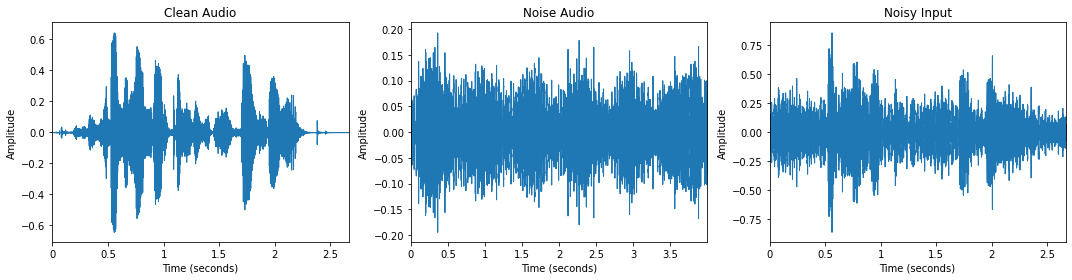

In [0]:
clean_audio, sr = librosa.load(clean_filenames[0])
print('Clean Audio shape is %s and sample rate is %s Hz' %(clean_audio.shape, sr))  #Display the length of the audio array and sample rate

noise_audio, sr = librosa.load(noise_filenames[0])
print('Noise Audio shape is %s and sample rate is %s Hz' %(noise_audio.shape, sr))  #Display the length of the audio array and sample rate


noisy_audio=add_noise_to_clean_audio(clean_audio, noise_audio)
print('Noisy Audio shape is %s and sample rate is %s Hz' %(noisy_audio.shape, sr))  #Display the length of the audio array and sample rate

plt.figure(figsize=(15, 4));
plt.subplot(1, 3, 1);
librosa.display.waveplot(clean_audio, sr=sr)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Clean Audio')
ipd.display(ipd.Audio(data=clean_audio, rate=sr))

plt.subplot(1, 3, 2);
librosa.display.waveplot(noise_audio, sr=sr)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Noise Audio')
ipd.display(ipd.Audio(data=noise_audio, rate=sr))


plt.subplot(1, 3, 3);
librosa.display.waveplot(noisy_audio, sr=sr)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Noisy Input')
ipd.display(ipd.Audio(data=noisy_audio, rate=sr))

plt.tight_layout()

This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono. The same can be seen for clean, noise and noisy audio.



 ## Frequency-domain representation
Deifine function to calculate FFT on our clean, noise, noisy audio=(clean +noise) 

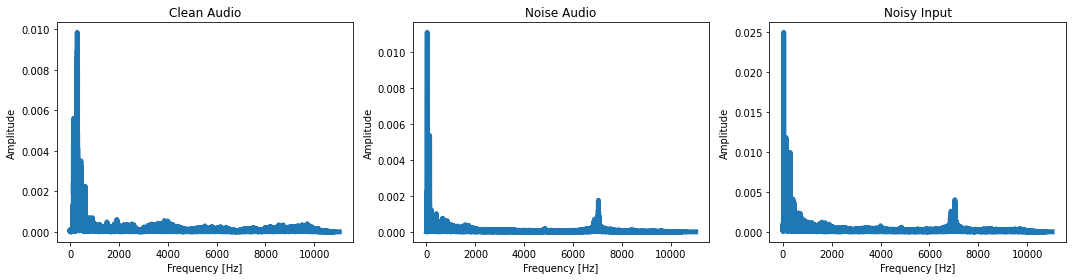

In [0]:
def fft_cal(filepath, sample_rate):
  n=len(filepath)
  #print(n)
  freq=np.fft.rfftfreq(n, d=1./sample_rate)
  mag=abs(np.fft.rfft(filepath/n))
  return (mag,freq)




fft_magc, fft_freqc=fft_cal(clean_audio,sample_rate=sr)
fft_magn, fft_freqn=fft_cal(noise_audio,sample_rate=sr)
fft_magna, fft_freqna=fft_cal(noisy_audio,sample_rate=sr)

plt.figure(figsize=(15, 4));
plt.subplot(1, 3, 1);

plt.plot(fft_freqc,fft_magc,linewidth=5)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.title('Clean Audio')



plt.subplot(1, 3, 2);
plt.plot(fft_freqn,fft_magn,linewidth=5)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.title('Noise Audio')



plt.subplot(1, 3,3);
plt.plot(fft_freqna,fft_magna,linewidth=5)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Frequency [Hz]')
plt.title('Noisy Input')

plt.tight_layout()

We are plotting frequencies ranging from 0 to 11kHz because our signal was sampled at 22k sampling rate and according to the **Nyquist sampling theorem**, it should only posses frequencies ≤ 11000Hz (22000/2). Here we notice two points:

1. Since magnitudes of frequency values > 4000 are very small, **we are going to downsample the audio signals**(from both datasets) to 8kHz and **will remove the silent frames** from it. The goal is to reduce the amount of computation and dataset size.


2. When we applied FFT to our signal, it gave us only frequency values and we lost the track of time information. To calculate features for our system such that it has frequency values along with the time at which they were observed, we will apply  STFT. The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

## Spectogram (STFT):  

To adapt our image denoising NN for audio processing ,audio signals are  transformed into (time/frequency) 2D representations. We compute spectogram using magnitudes of the Short-Time Fourier Transform as below:


1. Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. 

2. Since we will set window_length = n_fft, and  it is recommended to set n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm, therefore, we will set our window_ms = 16ms .

3. Further, to reduce **spectral leakage** we will use raised cosine window (“hann”), which is adequate for most applications in audio signal processing.

4. To  compensate for the signal attenuation at the window edges, we will set stride_ms = 25% of window_ms. This will allow us to have a overlap of 75%.

5. window_length= Length of each block of samples to pass to FFT.
6. stride_length=Advance (in samples) between each frame passed to FFT.


In [0]:
window_ms = 0.016 # 16 ms Length of each block of samples to pass to FFT.
stride_ms= .25*window_ms # (25% of window, i.e., 75 % overlap) #  compensates for the signal attenuation at the window edges
sample_rate= 16e3
duration=0.51

window_length, stride_length =  window_ms * sample_rate, stride_ms * sample_rate  # Convert from seconds to samples
print('Window Length is: %s and Window Step is: %s' %(window_length ,stride_length))

freq_bins=librosa.fft_frequencies(sr=sample_rate, n_fft=int(window_length))

Window Length is: 256.0 and Window Step is: 64.0


Define the functions to:
1. Obtain stft spectogram
2. Calculate the short-time Fourier transform  magnitude and phase
3. Obtaining audio from stft spectogram
4. Plotting stft spectogram

In [0]:
def get_stft_spectrogram(audio):
        return librosa.stft(audio, n_fft=int(window_length), win_length=int(window_length), hop_length= int(stride_length),
                            window=scipy.signal.windows.hann, center=True)
def get_stft_mag_phase( stft_features):
        return (np.abs(stft_features),  np.angle(stft_features))
        
def get_audio_from_stft_spectrogram( stft_features):
        return librosa.istft(stft_features, win_length=int(window_length), hop_length=int(stride_length),
                             window=scipy.signal.windows.hann, center=True)                
                           

def plot_stft_spectogram (stft_features):    
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_features),ref=np.max), y_axis='log', x_axis='time')
        plt.title('Power spectrogram')
        plt.colorbar(format='%+2.0f dB')
      


    

Clean Audio Spectogram shape:  (129, 128)
Noise Audio Spectogram shape:  (129, 128)
Noisy Input Spectogram shape:  (129, 128)


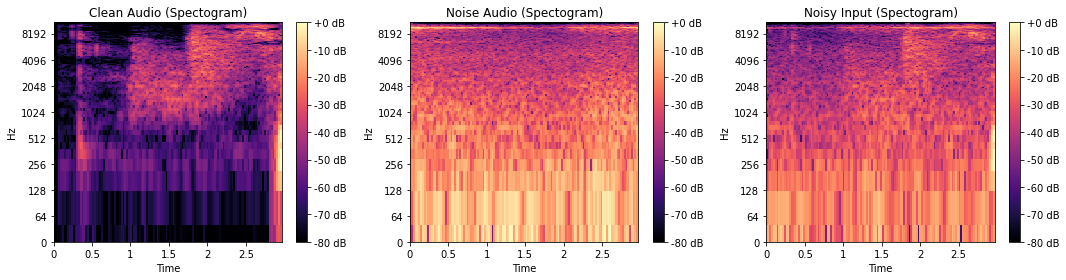

In [0]:
clean_audio,_=read_audio(clean_filenames[0], sample_rate)
clean_audio=remove_silence(clean_audio)
clean_audio = audio_random_crop(clean_audio,sample_rate, duration=duration)
#print('CleanAudio: ', clean_audio.shape)
clean_audio_stft_features=get_stft_spectrogram(clean_audio)

clean_audio_stft_mag_phase=get_stft_mag_phase( clean_audio_stft_features) # Obtain magnitude and phase of stft
print('Clean Audio Spectogram shape: ',clean_audio_stft_features.shape)




noise_audio,_=read_audio(noise_filenames[0], sample_rate)
noise_audio=remove_silence(noise_audio)
noise_audio = audio_random_crop(noise_audio,sample_rate, duration=duration)

noise_audio_stft_features=get_stft_spectrogram(noise_audio)
print('Noise Audio Spectogram shape: ',noise_audio_stft_features.shape)


noisy_input = add_noise_to_clean_audio(clean_audio, noise_audio)
noisy_input_stft_features=get_stft_spectrogram(noisy_input)
print('Noisy Input Spectogram shape: ',noisy_input_stft_features.shape)


noisy_input_stft_mag_phase=get_stft_mag_phase(noisy_input_stft_features)

mean = np.mean(noisy_input_stft_features)
std = np.std(noisy_input_stft_features)
noisy_input_stft_features = (noisy_input_stft_features - mean) / std



plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
plot_stft_spectogram (clean_audio_stft_features)
plt.title('Clean Audio (Spectogram)')
ipd.display(ipd.Audio(data=clean_audio, rate=sample_rate))


plt.subplot(1, 3, 2);
plot_stft_spectogram (noise_audio_stft_features)
plt.title('Noise Audio (Spectogram)')
ipd.display(ipd.Audio(data=noise_audio, rate=sample_rate))


plt.subplot(1, 3, 3);
plot_stft_spectogram (noisy_input_stft_features)
plt.title('Noisy Input (Spectogram)')
ipd.display(ipd.Audio(data=noisy_input, rate=sample_rate))

plt.tight_layout()





From here, we can feed the STFT features to NN or we can proceed further by computing Mel-frequency Cepstral Coefficients (MFCCs) and using them as features.

##Spectogram (STFT) to  MelSpectogram (Mel-scaled filter banks):
MelSpectogram mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. Defining the functions:

1. Getting mel spectogram
2. Obtaining audio from mel spectogram
3. Plotting mel spectogram

In [0]:
n_mels=32

In [0]:
def get_mel_spectrogram(audio):
       D = np.abs(get_stft_spectrogram(audio))**2
       return librosa.feature.melspectrogram(S=D, sr=sample_rate,n_mels=n_mels)
       

def get_audio_from_mel_spectrogram( M):
        return librosa.feature.inverse.mel_to_audio(M, sr=sample_rate, n_fft=int(window_length), hop_length=int(stride_length),
                                             win_length=int(window_length), window=scipy.signal.windows.hann,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None) 

def plot_mel_spectogram (clean_audio):         
        S_dB = librosa.power_to_db(get_mel_spectrogram(clean_audio), ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time',  y_axis='mel', sr=sample_rate)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')                             

To obtain melspectogram, we partition the Hz scale into bins (Figure on the left), and transforms each bin into a corresponding bin in the Mel Scale, using overlapping triangular filters (Figure in the center). Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown in the figure in the center.

**Mel Spectogram of Clean Auduio**

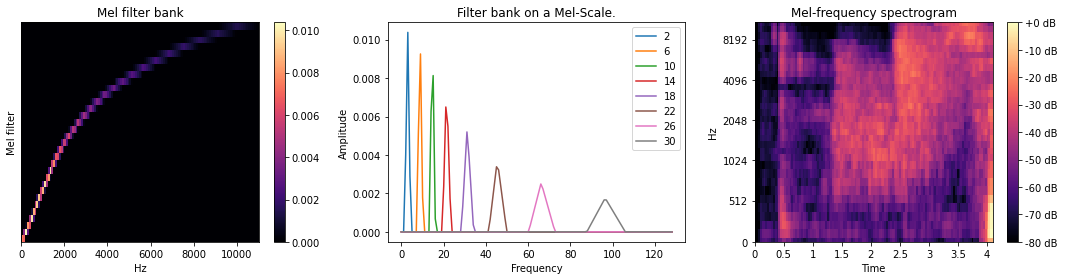

In [0]:
melfb = librosa.filters.mel(sr=sample_rate, n_fft=int(window_length), n_mels=n_mels)   # Filter banks

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
nfft= int(window_length)
mel_points = np.linspace(low_freq_mel, high_freq_mel, n_mels + 2)  # Equally spaced in Mel scale

hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((nfft + 1) * hz_points / sample_rate)



plt.figure(figsize=(15, 4));
plt.subplot(1, 3, 1);
librosa.display.specshow(melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()



plt.subplot(1, 3, 2);
idxs_to_plot = range(1,n_mels,4)
for i in idxs_to_plot:
    plt.plot(melfb[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Filter bank on a Mel-Scale.');


plt.subplot(1, 3, 3);
S_dB = librosa.power_to_db(get_mel_spectrogram(clean_audio), ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',  y_axis='mel', sr=sample_rate)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')


plt.tight_layout()




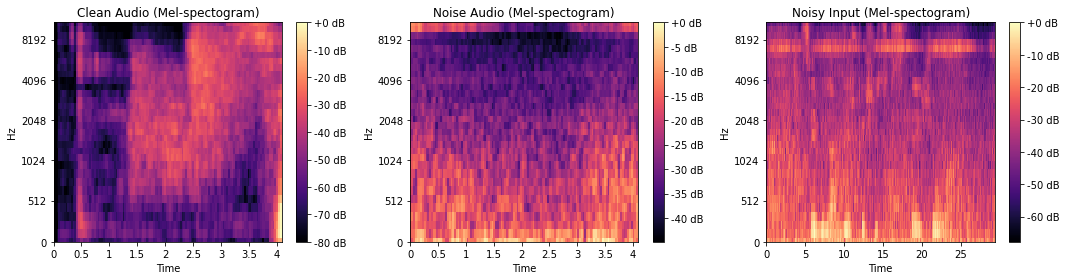

In [0]:
plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
plot_mel_spectogram (clean_audio)
plt.title('Clean Audio (Mel-spectogram)')

plt.subplot(1, 3, 2);
plot_mel_spectogram (noise_audio)
plt.title('Noise Audio (Mel-spectogram)')

plt.subplot(1, 3, 3);
plot_mel_spectogram (noisy_audio)
plt.title('Noisy Input (Mel-spectogram)')

plt.tight_layout()

One could feed the mel spectogram to NN or can proceed further to extract third features MFCC.

## From Mel Spectogram to Mel-frequency Cepstral Coefficients (MFCCs)

It turns out that mel-scaled filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks.

In [0]:
n_mfcc=20
def get_mfcc_spectrogram(audio):
     D = np.abs(get_stft_spectrogram(audio))**2
     MS= librosa.feature.melspectrogram(S=D, sr=sample_rate,n_mels=n_mels)
     return librosa.feature.mfcc(S=librosa.power_to_db(MS), n_mfcc=n_mfcc)

def plot_mfcc_spectogram (mfcc):  
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    
    

(20, 128)


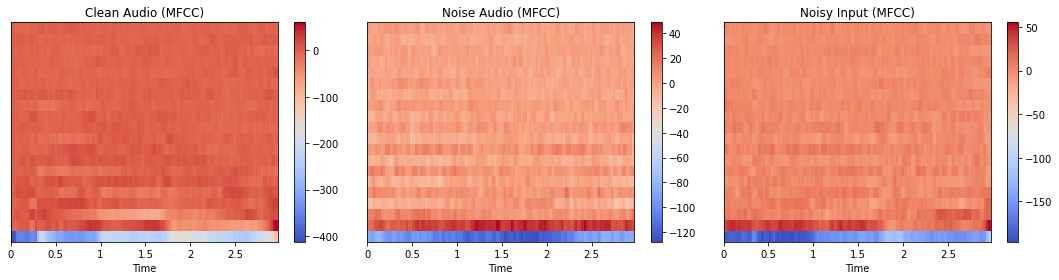

In [0]:
clean_audio_mfcc=get_mfcc_spectrogram(clean_audio)
print(clean_audio_mfcc.shape)

noise_audio_mfcc=get_mfcc_spectrogram(noise_audio)
noisy_input_mfcc=get_mfcc_spectrogram(noisy_input)

plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
plot_mfcc_spectogram (clean_audio_mfcc)
plt.title('Clean Audio (MFCC)')
plt.subplot(1, 3, 2);
plot_mfcc_spectogram (noise_audio_mfcc)
plt.title('Noise Audio (MFCC)')
plt.subplot(1, 3, 3);
plot_mfcc_spectogram (noisy_input_mfcc)
plt.title('Noisy Input (MFCC)')
plt.tight_layout()

**Spectogram and Mel Spectogram of Noise Auduio**

MFCCs are commonly derived as follows:

Take the Fourier transform of (a windowed excerpt of) a signal.
Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
Take the logs of the powers at each of the mel frequencies.
Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
The MFCCs are the amplitudes of the resulting spectrum.

## Features Extraction

We will extract STFT, Mel Spectogram and MFCC features. 







One could select which features, we want to feed to NN: here we are selecting MFCC to reduce computational cost.

In [0]:
features_list=['stft', 'mel', 'mfcc']
features=features_list[2]  # We are selecting mfcc
print('Features selected %s' %(features))
n_mels =32
n_mfcc=20
#numFeatures  = int(window_length//2 + 1)
numSegments  = 5
num_files=5000
duration=0.51
samples_duration=128


Features selected mfcc


We will define the fucntions:

1. To randomly choose noise and clean audio file

2. Function which performs audio processig:
   1. Reading the audio file
   2. Removing Silence
   3. Randomly cropping (one could skip this step)
   4. adding noise to clean audio
   5. Extract STFT features and return their  normalized version
   6. Extract mel-scaled filter banks coefficient return their  normalized    version
   7. Extract MFCCs return their  normalized version

3. Function that creates segments of noisy input to be fed to NN. Here the important thing is that we extracting 5 patches from noisy input and corresponding 5 patches from clean audio. 

In [0]:
def sample_noise_filename():
        return np.random.choice(noise_filenames)
f_name=sample_noise_filename()


def sample_clean_filename():
        return np.random.choice(clean_filenames)

clean_filenames_random_list=[]
for i in range(0,6000):
  cfnames=sample_clean_filename()
  clean_filenames_random_list.append(cfnames)


def audio_processing(clean_filename, sample_rate=16e3):

        clean_audio, _ = read_audio(clean_filename, sample_rate)
        # remove silent frame from clean audio
        clean_audio = remove_silence(clean_audio)
        # sample random fixed-sized snippets of audio
        clean_audio = audio_random_crop(clean_audio,sample_rate, duration=duration)
        # extract stft features from clean audio 


        # choose the noise filename randomly
        noise_filename = sample_noise_filename()
        # read the noise filename
        noise_audio, sr = read_audio(noise_filename, sample_rate)
        # remove silent frame from noise audio
        noise_audio = remove_silence(noise_audio)
        # add noise to input image
        noisy_input = add_noise_to_clean_audio(clean_audio, noise_audio)
       



        scaler = StandardScaler(copy=False, with_mean=True, with_std=True)

        if (features==features_list[0]):
          clean_audio_stft_features=get_stft_spectrogram(clean_audio)
          # extract magnitude and phase   from noisy audio stft features
          clean_mag, clean_phase=  get_stft_mag_phase(clean_audio_stft_features)
          # extract stft features from noisy audio
          noisy_input_stft_features=get_stft_spectrogram(noisy_input)

         
          # extract magnitude and phase   from noisy audio stft features
          noisy_mag, noisy_phase=  get_stft_mag_phase( noisy_input_stft_features)

          noisy_magnitude = scaler.fit_transform(noisy_mag)
          clean_magnitude = scaler.transform(clean_mag)
          return noisy_magnitude, clean_magnitude, noisy_phase


        elif (features==features_list[1]) :
          clean_mel =get_mel_spectrogram(clean_audio)
          noisy_mel =get_mel_spectrogram(noisy_input)
          noisy_mel_scaled = scaler.fit_transform(noisy_mel)
          clean_mel_scaled = scaler.transform(clean_mel)
          return noisy_mel_scaled, clean_mel_scaled 

        else:
         clean_mfcc =get_mfcc_spectrogram(clean_audio)
         noisy_mfcc =get_mfcc_spectrogram(noisy_input)
         noisy_mfcc_scaled= scaler.fit_transform(noisy_mfcc)
         clean_mfcc_scaled= scaler.fit_transform(clean_mfcc)
         return noisy_mfcc_scaled, clean_mfcc_scaled 

def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments
        

 Creating the dataset using above defined functions.

In [0]:
if features=='mel' or features=='mfcc':

    def create_mel_dataset():
      print('Creating %s dataset' %(features))
      out = [audio_processing(filename, sample_rate) for filename in clean_filenames_random_list[0:num_files]]
      noisy_features=[]
      clean_features=[]
   
      for o in out:

                

                noisy_features = o[0]
                clean_features = o[1]
                #print(noisy_features.shape)

                noisy_features = prepare_input_features(noisy_features, numSegments=numSegments, numFeatures=clean_features.shape[0])
                noisy_features = np.transpose(noisy_features, (2, 0, 1))
                noisy_features = np.expand_dims(noisy_features, axis=3)

                #clean_features = np.transpose(clean_features, (1, 0))
                #clean_features = np.expand_dims(clean_features, axis=2)
                #clean_features = np.expand_dims(clean_features, axis=2)

                clean_features = prepare_input_features(clean_features, numSegments=numSegments, numFeatures=clean_features.shape[0])
                clean_features = np.transpose(clean_features, (2, 0, 1))
                clean_features = np.expand_dims(clean_features, axis=3)
               
                

                
                noisy_features.append(noisy_features)
                clean_features.append(clean_features)
                
      return np.asarray(noisy_features), np.asarray(clean_features)  
else:

   def create_dataset():
     print('Creating %s dataset' %(features_list[0]))
     
     out = [audio_processing(filename, sample_rate) for filename in clean_filenames_random_list[0:num_files]]
    
     noisy_features=[]
     clean_features=[]
     noisy_phase=[]
     counter=0
     for o in out:
               

                noisy_features = o[0]
                clean_features = o[1]
                noisy_stft_phase = o[2]

                

                noisy_features = prepare_input_features(noisy_features, numSegments=numSegments, numFeatures=clean_features.shape[0])
                noisy_features = np.transpose(noisy_features, (2, 0, 1))
                noisy_features = np.expand_dims(noisy_features, axis=3)

                clean_features = prepare_input_features(clean_features, numSegments=numSegments, numFeatures=clean_features.shape[0])
                clean_features = np.transpose(clean_features, (2, 0, 1))
                clean_features = np.expand_dims(clean_features, axis=3)

                #clean_features = np.transpose(clean_features, (1, 0))
                #clean_features = np.expand_dims(clean_features, axis=2)
                #clean_features = np.expand_dims(clean_features, axis=2)

                noisy_stft_phase = np.transpose(noisy_stft_phase, (1, 0))
                

                
                noisy_features.append(noisy_features)
                clean_features.append(clean_features)
                noisy_phase.append(noisy_stft_phase)
                

     return np.asarray(noisy_features), np.asarray(clean_features),  np.asarray(noisy_phase) 

We have created the dataset and will load from the drive and will skip the creation of data.

In [0]:
'''
features='stft'
if features=='mel' or features=='mfcc':
  
  X,y=create_mel_dataset()
 
else:
  
  X,y,phase=create_dataset()


print(X.shape)
noisy_input_audio=X.reshape(X.shape[0]*X.shape[3],X.shape[2]*X.shape[1]*X.shape[4])
print(noisy_input_audio.shape)

print(y.shape)
clean_org_audio=y.reshape(y.shape[0]*y.shape[3],y.shape[2]*y.shape[1]*y.shape[4])
print(clean_org_audio.shape)


#saving the data numpy arrays
np.savetxt("/tmp/audio_data/noisy_input_audio_stft.csv", noisy_input_audio, delimiter=",")
np.savetxt("/tmp/audio_data/clean_org_audio_stft.csv",clean_org_audio,delimiter=",")
'''



### Loading the data that we have already created and choosing 'mfcc.

In [0]:
if features=='mfcc':

   !cp -r  "/content/drive/My Drive/Audio_Data/audio_data/noisy_input_audio_mfcc.csv" "/tmp/audio_data"
   !cp -r  "/content/drive/My Drive/Audio_Data/audio_data/clean_org_audio_mfcc.csv" "/tmp/audio_data"



In [0]:
noisy_input_audio_df=pd.read_csv('/tmp/audio_data/noisy_input_audio_mfcc.csv',header=None)
print(noisy_input_audio_df.shape)
clean_org_audio_df=pd.read_csv('/tmp/audio_data/clean_org_audio_mfcc.csv',header=None)
print(clean_org_audio_df.shape)



(25000, 2560)
(25000, 2560)


### Reshaping the training and testing data dependiping upon if we want to use lstm or conv_lstm.

In [0]:
choose_model='lstm'

In [0]:
if choose_model=='lstm':
   print('lstm')
   clean_org_audio =clean_org_audio_df.values.reshape(num_files,numSegments,n_mfcc*samples_duration)
   print(clean_org_audio.shape)

   noisy_input_audio= noisy_input_audio_df.values.reshape(num_files,numSegments,n_mfcc*samples_duration)
   print(noisy_input_audio.shape)

   output_shape=(1, n_mfcc*samples_duration )
   print(output_shape)

else:
   clean_org_audio =clean_org_audio_df.values.reshape(num_files,numSegments,n_mfcc,samples_duration,1)
   print(clean_org_audio.shape)

   noisy_input_audio= noisy_input_audio_df.values.reshape(num_files,numSegments,n_mfcc,samples_duration,1)
   print(noisy_input_audio.shape)
   
   output_shape=(1, n_mfcc,samples_duration,1 )
   print(output_shape)


lstm
(5000, 5, 2560)
(5000, 5, 2560)
(1, 2560)


Splitting the training and testing data

In [0]:
training_portion=0.8
split_patches= int(training_portion*(noisy_input_audio.shape[0]))
print('Number of train patches: ', split_patches)
print('Number of test patches: ', len(noisy_input_audio)-split_patches)


original_train_patches=clean_org_audio[:split_patches, :,:]
print('Original train patches: ', original_train_patches.shape)
noisy_train_patches= noisy_input_audio[:split_patches, :,:]
print('Noisy train patches: ', noisy_train_patches.shape)

original_test_patches=clean_org_audio[split_patches:, :,:]
print('Original test patches: ', original_test_patches.shape)
noisy_test_patches=noisy_input_audio[split_patches:, :,: ]
print('Noisy test patches: ',noisy_test_patches.shape)

Number of train patches:  4000
Number of test patches:  1000
Original train patches:  (4000, 5, 2560)
Noisy train patches:  (4000, 5, 2560)
Original test patches:  (1000, 5, 2560)
Noisy test patches:  (1000, 5, 2560)


## Defining conv_lstm model

In [0]:
seq_len=numSegments
features_len =n_mfcc
units= samples_duration*features_len

def create_conv_lstm_model(): 

  conv_lstm_model = Sequential([  
                       
       TimeDistributed(
            Conv2D(16, (3,3),padding='same', strides=(2,2) ,kernel_initializer='he_normal'), 
            input_shape=(seq_len, features_len, samples_duration, 1),
                  ),
       TimeDistributed(
           BatchNormalization(),
                 ),
      TimeDistributed(
           Activation("relu"),
                ),
     TimeDistributed(
        MaxPooling2D((2,2))
                ), 

     TimeDistributed(
             Flatten(),
          ),


    LSTM(units,return_sequences=False),
    
    Dense(units,activation='relu'),
    Dense(units,activation='sigmoid'),
    Reshape(output_shape)
    ])
  
  return conv_lstm_model



## Defining LSTM Model

In [0]:
features_len =n_mfcc
units= samples_duration*features_len
def create_lstm_model(): 

  lstm_model = Sequential([  
  
    LSTM(units, input_shape=(numSegments,samples_duration*features_len)),
    RepeatVector(5),
    LSTM(units, return_sequences=True),
    TimeDistributed(Dense(units,activation='relu')),
    Dropout(0.2),
    TimeDistributed(Dense(units,activation='linear'))
    ])
  
  return lstm_model




## Selecting the Model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 2560)              52439040  
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 5, 2560)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 5, 2560)           52439040  
_________________________________________________________________
time_distributed_12 (TimeDis (None, 5, 2560)           6556160   
_________________________________________________________________
dropout (Dropout)            (None, 5, 2560)           0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 5, 2560)           6556160   
Total params: 117,990,400
Trainable params: 117,990,400
Non-trainable params: 0
________________________________________

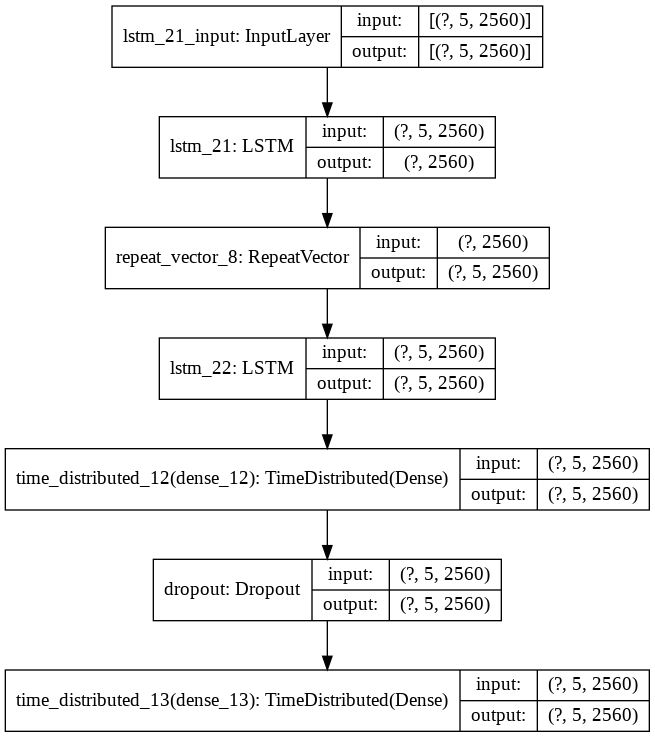

In [0]:
if choose_model=='lstm':
   model=create_lstm_model()
else:
   model=create_conv_lstm_model()


model.summary()
from tensorflow.keras.utils import  plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)  




### Tuning the hyper-parameters

In [0]:
num_epochs=100
batch_size=50
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
if choose_model=='lstm':
   model=create_lstm_model()
else:
  model=create_conv_lstm_model()


model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches,
    original_train_patches,
    epochs=num_epochs, validation_split=0.2,
    batch_size=batch_size,
    callbacks=[lr_schedule], verbose=1)

Text(0.5, 0, 'Learning Rate')

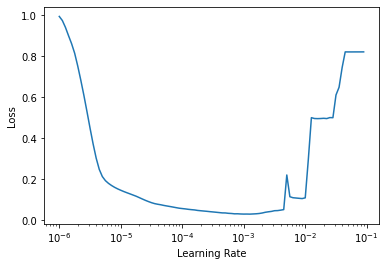

In [0]:
lrs = 1e-6 * (10 ** (np.arange(num_epochs) / 20))
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-5,0.9, 0, .2])
plt.ylabel('Loss')
plt.xlabel('Learning Rate')

We can  inspect the lower part of the curve before it gets unstable. We will set the learning rate to be 1e-4 to 3e-3 and will compile and train our model in the next steps.

## Compiling and training the model

In [0]:
if choose_model=='lstm':
   model=create_lstm_model()
else:
  model=create_conv_lstm_model()

batch_size=50
num_epochs=100

optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer=optimizer, loss='mse')



history = model.fit( noisy_train_patches,
    original_train_patches,
     validation_split=0.2,
    batch_size=batch_size, 
    epochs=num_epochs, verbose=1)

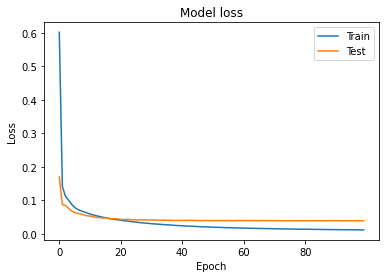

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.axis([0,100, 0, 0.09])
plt.xticks(np.arange(0, num_epochs, 20))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Evaluate the model

In [0]:
train_loss = model.evaluate(noisy_train_patches,  original_train_patches,verbose=0)
test_loss = model.evaluate(noisy_test_patches,  original_test_patches,verbose=0)
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

Train Loss: 0.014, Test Loss: 0.038
